In [13]:
# Nonlinear dynamics JC
# 2D nonlinear system example (fixed points)
# =========================================================================
%reset -f
import os, sys
import numpy as np
import pandas as pd
from numpy import linalg as ln
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize
from jax import jacfwd, jacrev
import jax.numpy as jnp
from pprint import pprint

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))

# Define local functions
def hessian(f): return jacfwd(jacrev(f))

%who

DIR_HERE	 hessian	 integrate	 jacfwd	 jacrev	 jnp	 ln	 np	 optimize	 
os	 pd	 plt	 pprint	 scipy	 sys	 


In [14]:
# ANALYSIS 0: Set up a dynamical system
# ========================

# Define functions of a dynamical system (2 dimensional)
def f1(x1, x2): return((1 - x1 ** 2) * x2) # function 1
def f2(x1, x2): return((x1 /2) - x2) # function 2

# Define functions for minima detection
def dyn_2d(xs): return([f(xs[0], xs[1]) for f in list([f1, f2])]) # apply f1 and d2 to x1 and x2
def qf(Fx): return(.5 * ln.norm(Fx) ** 2) # q(x) = EQ3.5(Succillo and Barak, 2012)


In [ ]:
# Note about analytic solution (by Rex Liu)
# def f1(x1, x2): return((1 - x1 ** 2) * x2) # function 1
# def f2(x1, x2): return((x1 /2) - x2) # function 2
# ========================

# By definition, fixed points are the values of x at which x-dot = 0. 
# In other words, we’re looking for the values x1 and x2 for which both x1-dot and x2-dot are simultaneously zero. 
# So if you set x1-dot and x2-dot to zero in equations (3.8) & (3.9), you get two equations for x1 and x2:

# 1) 0 = (1 - x1^2) * x2
# 2) 0 = x1/2 - x2

# Solving these will give you the location of the fixed points exactly. 
# It’s easiest to start with equation (1). Note that there are two ways this can be zero: (a) x2 = 0 or (b) (1 - x1^2) = 0, or equivalently x1^2 = 1. 
# Solving case (b) gives fixed points at x1 = +/- 1. So we have a total of three fixed points. 
# Now use equation (2) to find the missing coordinate of these fixed points. 
# If x2 = 0, then (2) implies x1 = 0 — so one fixed point is at (0,0). 
# Otherwise, note that (2) implies x2 = x1/2. So if x1 = +1, then x2 = +1/2, and if x1 = -1, then x2 = -1/2. 
# That means, the other two fixed points are at (-1, -1/2) and (1, 1/2).


In [15]:
# ANALYSIS 1: Phase space
# ========================

# Define range of (arbitrary) phase space
x1_r = np.linspace(-2, 2, 200)
x2_r = np.linspace(-1, 1, 100)
q = np.zeros((len(x1_r),len(x2_r)))
Js = list()

# Loop over the entire phase space to get q
# small qs are fixed poitns 
for d1_i, x1 in enumerate(x1_r):
    for d2_i, x2 in enumerate(x2_r):
        # Get output of f1 and f2
        xsets = np.array([x1, x2])
        Fx = dyn_2d(xsets)
        
        # Compute the norm of dynamics q(x)
        q[d1_i, d2_i] = qf(Fx)
        
        # Compute Jacobian
        #J = jacfwd(dyn_2d)(xsets)
        #J.append(np.array(J))
        
# q contains norm 
print(q)

[[4.5        4.32022243 4.14452607 ... 6.06371799 6.27981839 6.5       ]
 [4.2632564  4.09274659 3.92612471 ... 5.82602827 6.03264812 6.2431559 ]
 [4.03530871 3.8737189  3.71583084 ... 5.59644604 5.793926   5.99510771]
 ...
 [5.99510771 5.793926   5.59644604 ... 3.71583084 3.8737189  4.03530871]
 [6.2431559  6.03264812 5.82602827 ... 3.92612471 4.09274659 4.2632564 ]
 [6.5        6.27981839 6.06371799 ... 4.14452607 4.32022243 4.5       ]]


In [16]:
# ANALYSIS 2: Optimization to find minima
# ========================
# Define optimization related variables
nrepeat = 500
pic = np.random.choice
minima = np.zeros((nrepeat, 2))

# Run optimization with randomly picked initial conditions
for i in range(nrepeat):
    IC = [pic(x1_r), pic(x2_r)]
    r = optimize.minimize(lambda x: qf(dyn_2d(x)), IC)
    minima[i,:] = r['x'] if r['success'] else None
  
# Ignore small differences and get unique minimas
minima = np.unique(np.round(minima, 3), axis=0) 
print("Fixed points (x1, x2): \n", minima)

Fixed points (x1, x2): 
 [[-1.  -0.5]
 [ 0.   0. ]
 [ 1.   0.5]]


In [43]:
# ANALYSIS 3: Jacobian & Hessian
# ========================
J_eig = {'J_eigval': [], 'J_eigvec':[]}

for i in range(minima.shape[0]):
    print('---Analyzing FP %d---' % i) 
    
    # Calculate Jacobian matrix 
    J = jacfwd(dyn_2d)(minima[i,:])
    J = np.array(J)
    print("Jacobian:\n", J, "\n")

    # Do eigendecomposition of J
    J_eigval, J_eigvec = ln.eig(J)
    print("Eigenvector of J:\n", J_eigvec, "\n")
    print("Eigenvalue of J:\n", J_eigval, "\n")

    # Calculate Hessian matrix 
    H = hessian(dyn_2d)(minima[i,:])
    H = np.array(H)
    #print("Hessian:\n", H, "\n")
    
    # Keep it
    J_eig['J_eigval'].append(J_eigval)
    J_eig['J_eigvec'].append(J_eigvec)

# negative eigenvalues -> stable fixed points
# positive eigenvalues -> unstable fixed points

---Analyzing FP 0---
Jacobian:
 [[-1.   0. ]
 [ 0.5 -1. ]] 

Eigenvector of J:
 [[ 0.000000e+00  4.440892e-16]
 [ 1.000000e+00 -1.000000e+00]] 

Eigenvalue of J:
 [-1. -1.] 

---Analyzing FP 1---
Jacobian:
 [[ 0.   1. ]
 [ 0.5 -1. ]] 

Eigenvector of J:
 [[ 0.9390708  -0.5906905 ]
 [ 0.34372377  0.80689824]] 

Eigenvalue of J:
 [ 0.36602542 -1.3660254 ] 

---Analyzing FP 2---
Jacobian:
 [[-1.   0. ]
 [ 0.5 -1. ]] 

Eigenvector of J:
 [[ 0.000000e+00  4.440892e-16]
 [ 1.000000e+00 -1.000000e+00]] 

Eigenvalue of J:
 [-1. -1.] 



In [73]:
# # Testing Jaccobian detection (using polar cordinate transformation)
# # Define functions of a dynamical system (2 dimensional)
# def f1_t(r, theta): return(r * jnp.cos(theta)) 
# def f2_t(r, theta): return(r * jnp.sin(theta)) 
# def fun_t(r_theta): return([f(r_theta[0], r_theta[1]) for f in list([f1_t, f2_t])]) 

# # Jacobian
# i = jnp.array([2, 2], dtype='float32')
# J = jacfwd(fun_t)(i)
# J = np.array(J)
# print("Jacobian:\n", J, "\n")

# # Validation (analytic solution)
# # [cos(theta), -r*sin(theta); sin(theta), r*cos(theta)]
# def validate (i): return (np.array([np.cos(i[1]), -i[0] * np.sin(i[1]),
#                                     np.sin(i[1]), i[0] * np.cos(i[1])]).reshape([2, 2]))

# print("Jacobian (analytic): \n", validate(i),"\n")


Jacobian:
 [[-0.41614684 -1.8185948 ]
 [ 0.9092974  -0.8322937 ]] 

Jacobian (analytic): 
 [[-0.4161468 -1.8185948]
 [ 0.9092974 -0.8322936]] 



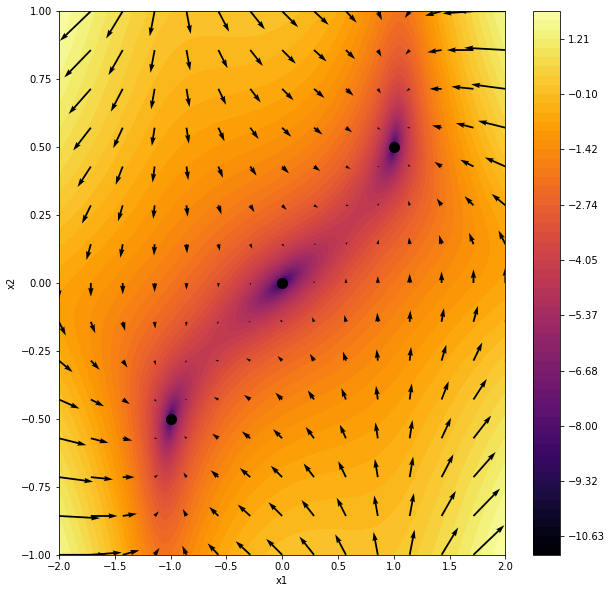

In [70]:
# ANALYSIS N: Plotting
# ========================

# Plot results!
fig, ax = plt.subplots(figsize=(10, 10))

# Contours
Z = np.log(q) # original q values
# Z = something else to check?
X1, X2 = np.meshgrid(x2_r, x1_r)
levels = np.linspace(Z.min(), Z.max(), 60)
contourf_ = ax.contourf(X2, X1, Z, levels=levels)
contourf_.set_cmap('inferno')
cbar = fig.colorbar(contourf_)

# Plot small q points
plt.scatter(minima[:, 0], minima[:, 1], color = "black", marker="o", s = 100)

# Plot vector field
X1, X2 = np.meshgrid(np.linspace(-2, 2, 15), np.linspace(-1, 1, 15))
plt.quiver(X1, X2, f1(X1, X2), f2(X1, X2))

# Plot vector of an unstable fixed point
# unstable_vec = J_eig['J_eigvec'][1][1]
# plt.quiver(*minima[1, :], *unstable_vec, color=['r'])

# Labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()